In [1]:
import math
import numpy as np
from sklearn import metrics as skmetrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.metrics import mean_squared_error, median_absolute_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['text.color'] = 'k'

In [ ]:
PARENT = "../"
DATA_FOLDER = PARENT + "data_WESCO/JUNE_JULY_EVAL/"
DATA_FOLDER_CACHE = DATA_FOLDER + 'cache_m3/'
VENUE = "WESCO"
VENUE_CONFIG_FILE = "WESCO_config.json"
OUTPUT_FOLDER = DATA_FOLDER_CACHE

In [ ]:
df = pd.read_csv(DATA_FOLDER_CACHE + VENUE + '.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])

In [14]:
# GET RID OF THE INITIAL TMS, GET INDEXES IN WHICH THE SENSOR(S) WE ARE ESTIMATING IS ACTIVE
NUM_SENSORS = 4
T = 5
clipped = df.sort_values(by='Date')[NUM_SENSORS * (T - 1):]
clipped = clipped.sort_values(by=['Site Num', 'Date'])
df = clipped
df.reset_index(drop=True, inplace=True)
active_indexes = df[df['status'] == 1].index

In [19]:
def read_json_config(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

config = read_json_config(DATA_FOLDER_CACHE + VENUE_CONFIG_FILE)

def mapping_room_placement(room):

    if room == "davinci":
        return "100"
    elif room == "metcalfe":
        return "101"
    elif room == "showroom":   
        return "102"
    elif room == "theater":
        return "103"

    return "unknown room"

def get_room_coordinates(room):
    coordinates = config[VENUE]["placements"][mapping_room_placement(room)]
    return (coordinates["row"], coordinates["column"])

def get_node_index(room):
    coords = get_room_coordinates(room)
    return coords[0] * config[VENUE]["width"] + coords[1]

In [ ]:
def compute_errors(true, pred, verbose = True):
    a, b = true, pred

    #rmse = root_mean_squared_error(a, b)
    #mdae = median_absolute_error(a, b)
    mae = mean_absolute_error(a, b)
    #r2 = r2_score(a, b)


    # The amplitude of the data considering 1st to 99th percentile.
    # If the 1st percentile is 20 and the 99th  percentile is 30, then percentile_range=30-20=10.
    percentile_range = np.percentile(a, 99) - np.percentile(a, 1)
    mean = np.mean(a)
    median = np.median(a)

    return {
        "mean": mean,
        "median": median,
        "r": percentile_range,
        "n": len(a),
        'MAE': mae,
        'MAE/mean': mae / mean,
        "MdAE": mdae,
        "MdAE/median": mdae / median,
        "MdAE/r": rmse / percentile_range,
        "RMSE": rmse,
        "RMSE/mean": rmse / mean,
        "R^2": r2
    }

In [17]:
with open(DATA_FOLDER_CACHE + "new_y.npy", "rb") as f:
    y = np.load(f)
    SIZE_DATA = y.shape[0] // 4

def get_index_room(room):
    if room == "theater":
        index = SIZE_DATA * 3
    if room == "showroom":
        index = SIZE_DATA * 2
    if room == "metcalfe":
        index = SIZE_DATA
    if room == "davinci":
        index = 0
    return index

In [18]:
NODES = config[VENUE]["width"] * config[VENUE]["height"]

In [19]:
def plot_GNN_prediction(room):  

    print(f"Plotting {room} predictions")
    index = get_node_index(room)

    with open(OUTPUT_FOLDER + f'{room}_outputs.npz', 'rb') as f:
        
        y_pred = np.load(f)
        #truths_h = y_pred["truth"].reshape(-1, NODES)[:SIZE_DATA,:][:,index]

        preds = y_pred["prediction"].reshape(-1, NODES)[:SIZE_DATA,:][:,index] # padding 
        site_num = int(mapping_room_placement(room))

        sensor_filtered = df[df['Site Num'] == site_num].reset_index(drop=True)
        preds = preds[sensor_filtered[sensor_filtered['status'] == 1].index]

        start_index = get_index_room(room)
        indices = [t for t in active_indexes if start_index <= t < start_index + SIZE_DATA]
        
        #ground = y[start_index : start_index + SIZE_DATA]
        ground = y[indices]

        print("Ground vs GNN")
        print(compute_errors(ground, preds))

        plt.figure(figsize=(8, 6))  # Optional: set the figure size
        #plt.plot(truths_h, label='Truth heatmap', color="orange")  # Plot the truth values
        plt.plot(ground, label=f'Ground Truth {room}', color="blue")  
        plt.plot(preds, label=f'Estimation {room}', color="red") 
        plt.xlabel('Time')
        plt.ylabel('PM2.5 Value')
        plt.title(f'PM2.5 Ground Truth vs Estimation {room}')
        plt.legend()
        plt.grid(True) 
        plt.tight_layout()  
        plt.show()


Plotting davinci predictions
Ground vs GNN
{'mean': 5.273247013188565, 'median': 4.925552641182652, 'r': 9.24623544603894, 'n': 1158, 'MAE': 0.22252470848664613, 'MAE/mean': 0.042198802356518565, 'MdAE': 0.19884709082866525, 'MdAE/median': 0.04037051379089941, 'MdAE/r': 0.031270295592256074, 'RMSE': 0.2891325155132333, 'RMSE/mean': 0.054830072399434986, 'R^2': 0.9839137819290568}


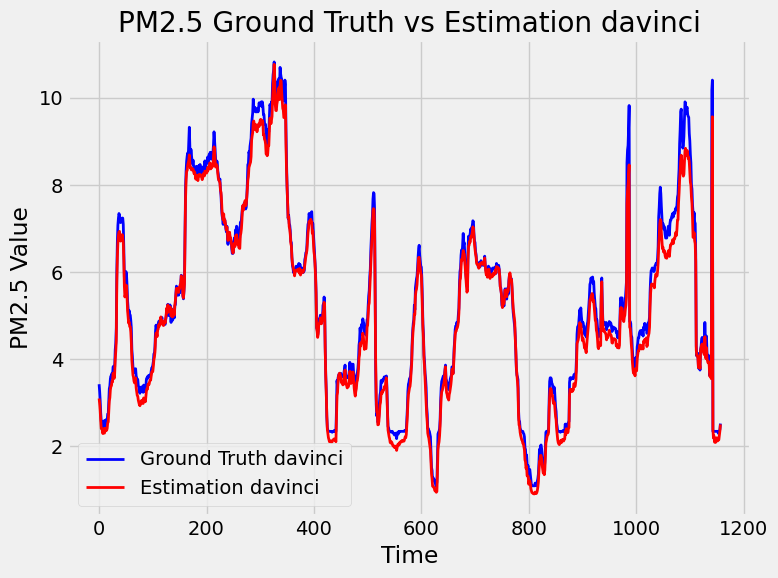

Plotting metcalfe predictions
Ground vs GNN
{'mean': 3.8343039292607726, 'median': 3.7166666667, 'r': 8.151333333399997, 'n': 1165, 'MAE': 1.2075965616985709, 'MAE/mean': 0.31494544615595643, 'MdAE': 1.0173469225898923, 'MdAE/median': 0.27372562939392864, 'MdAE/r': 0.17960172748819417, 'RMSE': 1.4639935480107396, 'RMSE/mean': 0.381814685277958, 'R^2': 0.3173972779266214}


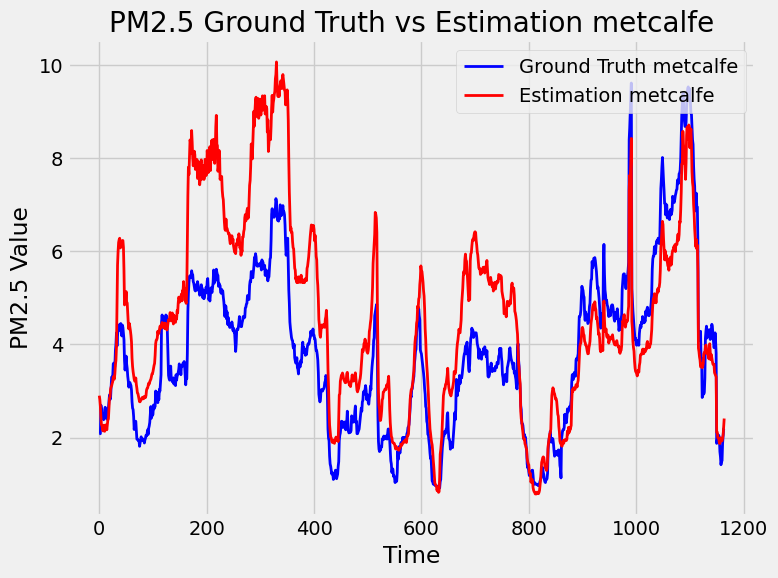

Plotting showroom predictions
Ground vs GNN
{'mean': 5.888977103980385, 'median': 5.198559573821613, 'r': 12.329927608731099, 'n': 1150, 'MAE': 1.4145250856876155, 'MAE/mean': 0.24019877488257374, 'MdAE': 0.8850317421469642, 'MdAE/median': 0.17024557083152778, 'MdAE/r': 0.15973195665923245, 'RMSE': 1.9694834624093096, 'RMSE/mean': 0.33443557813769176, 'R^2': 0.5810245886346426}


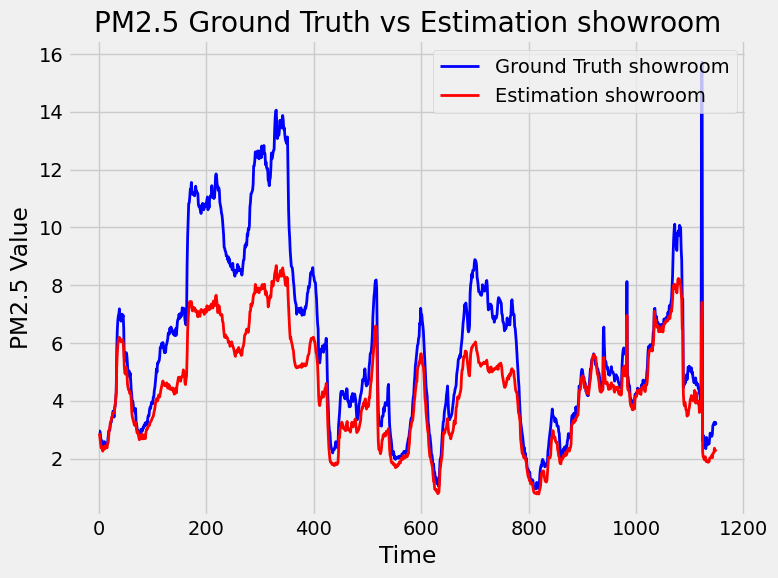

Plotting theater predictions
Ground vs GNN
{'mean': 5.2552793910288145, 'median': 5.090656700815814, 'r': 9.376279968314044, 'n': 1152, 'MAE': 0.5323441960769393, 'MAE/mean': 0.1012970303702014, 'MdAE': 0.48803600812620407, 'MdAE/median': 0.09586896874188998, 'MdAE/r': 0.06548699464713141, 'RMSE': 0.6140243960949873, 'RMSE/mean': 0.11683953419168853, 'R^2': 0.9292684922142481}


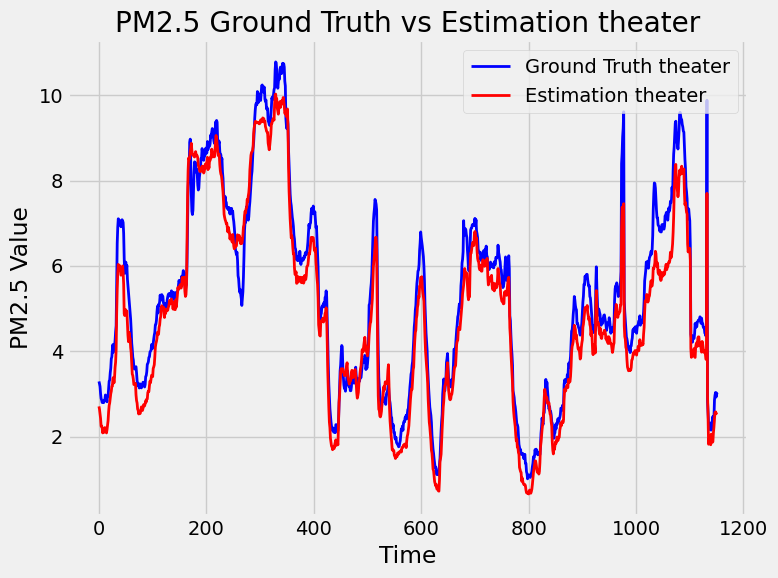

In [20]:
plot_GNN_prediction("davinci")
plot_GNN_prediction("metcalfe")
plot_GNN_prediction("showroom")
plot_GNN_prediction("theater")